Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
#from IPython.display import display, Image
from IPython.display import display
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

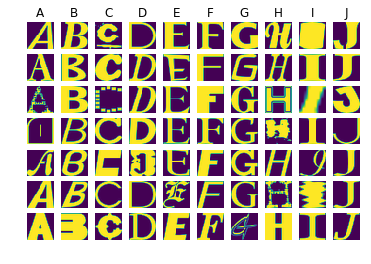

In [4]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
num_classes = len(classes)
samples_per_class = 7

for y, cls in enumerate(classes):
    folder = test_folders[y]
    files = os.listdir(folder)
    idxs = np.random.randint(1, len(files), size=samples_per_class)
    for i, idx in enumerate(idxs):
        im = ndimage.imread(folder + '/' + files[idx])
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(im.astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.show()


In [5]:
#
# Draft
#
#a = np.random.randint(0, 10, size=5)
#print(a)
#image_file = './notMNIST_large/A/a29ydW5pc2hpLnR0Zg==.png'
#im = ndimage.imread(image_file).astype('uint8')
#print(im.shape)
#plt.imshow(im)
#plt.show()


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

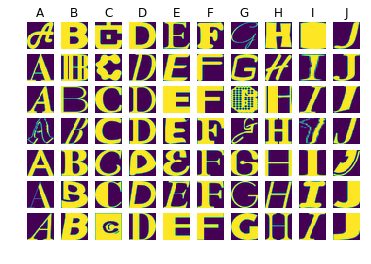

In [7]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
num_classes = len(classes)
samples_per_class = 7

for y, cls in enumerate(classes):
    class_dataset = np.load(test_datasets[y])    
    idxs = np.random.randint(0, class_dataset.shape[0], size=samples_per_class)
    for i, idx in enumerate(idxs):
        im = class_dataset[idx, :, :] * 255.0 + 128.0
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(im.astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.show()

In [8]:
#
# Draft
#
#print(train_datasets)

#test_data = np.load(test_datasets[0])
#print(test_data.shape)
#plt.imshow((test_data[0, :, :] * 255.0 + 128.0).astype('uint8'))

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [9]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
num_classes = len(classes)

print("------------ Train dataset ----------")
for y, cls in enumerate(classes):
    class_dataset = np.load(train_datasets[y])
    print("Class %s : " % cls, end="")
    print(class_dataset.shape)
    
print("\n")    

print("------------ Test dataset ----------")
for y, cls in enumerate(classes):
    class_dataset = np.load(test_datasets[y])
    print("Class %s : " % cls, end="")
    print(class_dataset.shape)


------------ Train dataset ----------
Class A : (52909, 28, 28)
Class B : (52911, 28, 28)
Class C : (52912, 28, 28)
Class D : (52911, 28, 28)
Class E : (52912, 28, 28)
Class F : (52912, 28, 28)
Class G : (52912, 28, 28)
Class H : (52912, 28, 28)
Class I : (52912, 28, 28)
Class J : (52911, 28, 28)


------------ Test dataset ----------
Class A : (1872, 28, 28)
Class B : (1873, 28, 28)
Class C : (1873, 28, 28)
Class D : (1873, 28, 28)
Class E : (1873, 28, 28)
Class F : (1872, 28, 28)
Class G : (1872, 28, 28)
Class H : (1872, 28, 28)
Class I : (1872, 28, 28)
Class J : (1872, 28, 28)


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [10]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [11]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [12]:
def plot_classes_samples(dataset, labels, classes, samples_per_class):
    num_classes = len(classes)
    
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(labels == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            im = dataset[idx, :, :] * 255.0 + 128.0
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(im.astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

------------ Training set ----------


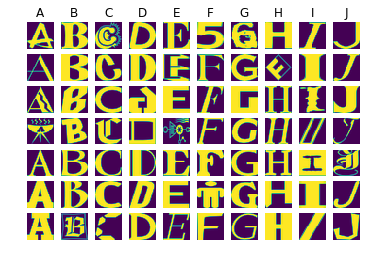

------------ Validation set ----------


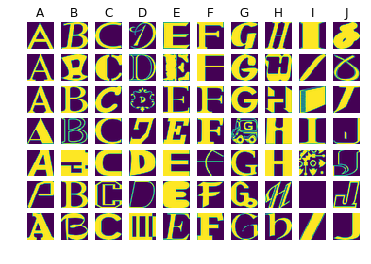

------------ Test set ----------


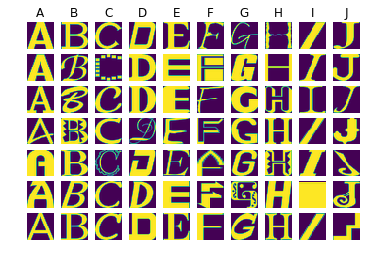

In [13]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
samples_per_class = 7

# train_dataset, train_labels
# test_dataset,  test_labels
# valid_dataset, valid_labels

print("------------ Training set ----------")
plot_classes_samples(train_dataset, train_labels, classes, samples_per_class)


print("------------ Validation set ----------")
plot_classes_samples(valid_dataset, valid_labels, classes, samples_per_class)


print("------------ Test set ----------")
plot_classes_samples(test_dataset, test_labels, classes, samples_per_class)


Finally, let's save the data for later reuse:

In [14]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [15]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size: %.2f [MB]' % float(statinfo.st_size / (1024 * 1024)))

Compressed pickle size: 658.80 [MB]


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

Optional questions answers:
 * Images that are almost identical are not considered as overlapped for our purposes.
   In my opinion those almost identical images are not skewing the results, but just some
   kind of data augmentation, that enlargens the datasets we have.
 * ok

In [16]:
import random

def display_overlap(overlap, source_dataset, target_dataset):
    item = random.choice(list(overlap.keys()))
    print("Source set image (%d)" % item)
    plt.figure()
    plt.imshow(source_dataset[item])
    plt.axis('off')
    plt.show()
    
    imgs = np.concatenate(([target_dataset[overlap[item][0:4]]]))
    print("Similar images")
    for i, img in enumerate(imgs):
        plt.subplot(1, 4, i + 1)
        plt.axis('off')
        plt.title("%d" % overlap[item][i])
        plt.imshow(img)

In [17]:
def extract_overlap(dataset_1, dataset_2):
    overlap = {}
    for i, img_1 in enumerate(dataset_1):
        for j, img_2 in enumerate(dataset_2):
            if np.array_equal(img_1, img_2):
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap

In [18]:
# train_dataset, train_labels
# test_dataset,  test_labels
# valid_dataset, valid_labels

%time overlap_test2valid = extract_overlap(test_dataset[:200], valid_dataset)

CPU times: user 8.12 s, sys: 44 ms, total: 8.16 s
Wall time: 8.11 s


Number of overlaps: 2
Source set image (155)


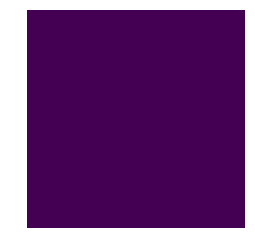

Similar images


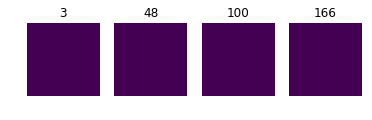

In [19]:
print('Number of overlaps:', len(overlap_test2valid.keys()))
display_overlap(overlap_test2valid, test_dataset[:200], valid_dataset)

Looking for overlapping images is pretty slow, due to double for loop that is being used. I will try to improve that by using numpy built-in broadcasting mechanism and having a single for loop:


In [20]:
def extract_overlap_v2(dataset_1, dataset_2):
    overlap = {}
    set1 = dataset_1.reshape(dataset_1.shape[0], 28 * 28)
    set2 = dataset_2.reshape(dataset_2.shape[0], 28 * 28)

    for i in range(set1.shape[0]):
        delta = set1[i, :] - set2
        dists = np.sum(np.abs(delta), axis=1)
        dups = np.where(dists == 0)
        if len(dups[0]):
            overlap[i] = dups[0]

    return overlap

In [21]:
# train_dataset, train_labels
# test_dataset,  test_labels
# valid_dataset, valid_labels

%time overlap_test2train = extract_overlap_v2(test_dataset[:200], valid_dataset)

CPU times: user 3.07 s, sys: 0 ns, total: 3.07 s
Wall time: 3.06 s


Number of overlaps: 2
Source set image (155)


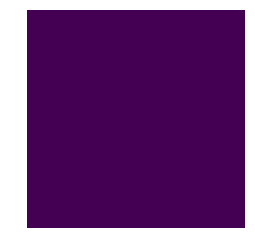

Similar images


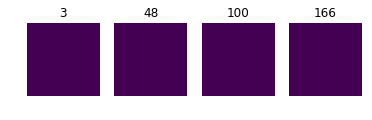

In [22]:
print('Number of overlaps:', len(overlap_test2train.keys()))
display_overlap(overlap_test2train, test_dataset[:200], valid_dataset)

Performance is still not sufficient enough for data sets sanitation, so I will try improving the v2 version by eliminating for loop and also adding ground truth labels comparison as a preprocessing phase to image comparison:

In [23]:
def extract_overlap_v3(dataset_1, label_1, dataset_2, label_2):

    overlap = {} 
    dataset_1 = dataset_1.reshape(dataset_1.shape[0], 28 * 28)
    dataset_2 = dataset_2.reshape(dataset_2.shape[0], 28 * 28)

    classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

    for i in range(len(classes)):
        idx1 = np.where(label_1 == i)
        idx2 = np.where(label_2 == i)

        if len(idx1[0]) == 0 or len(idx2[0]) == 0:
            continue

        set1 = dataset_1[idx1[0], :]
        set2 = dataset_2[idx2[0], :]

        dists = (set1**2).sum(axis = 1, keepdims = True) + \
                (set2**2).sum(axis = 1) - \
                2 * set1.dot(set2.T)

        dups = np.where(dists < 1e-6)
        if len(dups[0]):
            for dst, src in enumerate(dups[0]):
                if not idx1[0][src] in overlap.keys():
                    overlap[idx1[0][src]] = []
                overlap[idx1[0][src]].append(idx2[0][dups[1][dst]])
                #print("Source %d Dest %d" % (idx1[0][src], idx2[0][dups[1][dst]]))

    return overlap

In [24]:
# train_dataset, train_labels
# test_dataset,  test_labels
# valid_dataset, valid_labels

%time overlap = extract_overlap_v3(test_dataset, test_labels, valid_dataset, valid_labels)

CPU times: user 704 ms, sys: 760 ms, total: 1.46 s
Wall time: 194 ms


Number of overlaps: 148
Source set image (9662)


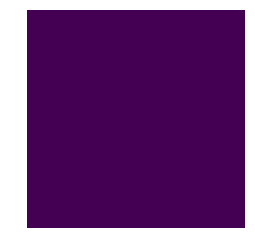

Similar images


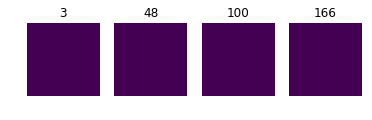

In [25]:
print('Number of overlaps:', len(overlap.keys()))
display_overlap(overlap, test_dataset, valid_dataset)

In [26]:
# Sanitize TEST DATASET
print("Sanitizing test dataset ... ", end="")
overlap = extract_overlap_v3(test_dataset, test_labels, test_dataset, test_labels)
values_duplicated = []
for key, value in overlap.items():
    if len(value) > 1:
        value.remove(key)
        values_duplicated += value

test_dataset_san = np.delete(test_dataset, np.asarray(values_duplicated), 0)
test_labels_san = np.delete(test_labels, np.asarray(values_duplicated), None)

print("DONE (%d records removed)" % len(list(set(values_duplicated))))

# Sanitize VALIDATION DATASET
print("Sanitizing validation dataset ... ", end="")
overlap = extract_overlap_v3(valid_dataset, valid_labels, valid_dataset, valid_labels)
values_duplicated = []
for key, value in overlap.items():
    if len(value) > 1:
        value.remove(key)
        values_duplicated += value

valid_dataset_san = np.delete(valid_dataset, np.asarray(values_duplicated), 0)
valid_labels_san = np.delete(valid_labels, np.asarray(values_duplicated), None)

print("DONE (%d records removed)" % len(list(set(values_duplicated))))


################### SANITY CHECKs ############################
overlap = extract_overlap_v3(test_dataset_san, test_labels_san, test_dataset_san, test_labels_san)
for key, value in overlap.items():
    assert (len(value) <= 1), "There is an element with more that 1 value (test set)"
        
overlap = extract_overlap_v3(valid_dataset_san, valid_labels_san, valid_dataset_san, valid_labels_san)
for key, value in overlap.items():
    assert (len(value) <= 1), "There is an element with more that 1 value (validation set)"


# Sanitize TEST Vs. VALIDATION DATASET
print("Sanitizing test to validation ... ", end="")
overlap = extract_overlap_v3(test_dataset_san, test_labels_san, valid_dataset_san, valid_labels_san)
values_duplicated = []
for key, value in overlap.items():
    assert (len(value) <= 1), "invalid number of overlap images"
    values_duplicated += value
if len(values_duplicated) > 0:
    valid_dataset_san = np.delete(valid_dataset_san, np.asarray(values_duplicated), 0)
    valid_labels_san = np.delete(valid_labels_san, np.asarray(values_duplicated), None)
print("DONE (%d records removed)" % len(list(set(values_duplicated))))

# Sanity check    
overlap = extract_overlap_v3(test_dataset_san, test_labels_san, valid_dataset_san, valid_labels_san)
for key, value in overlap.items():
    assert (len(value) == 0), "invalid number of overlap images"

    
# # Sanitize TEST Vs. TRAINING DATASET
# print("Sanitizing test to training ... ", end="")
# overlap = extract_overlap_v3(test_dataset_san, test_labels_san, train_dataset, train_labels)
# values_duplicated = []
# for key, value in overlap.items():
#     if len(value) > 0:
#         values_duplicated += value
# if len(values_duplicated) > 0:
#     train_dataset_san = np.delete(train_dataset, np.asarray(values_duplicated), 0)
#     train_labels_san = np.delete(train_labels, np.asarray(values_duplicated), None)
# print("DONE (%d records removed)" % len(list(set(values_duplicated))))

# # Sanity check
# overlap = extract_overlap_v3(test_dataset_san, test_labels_san, train_dataset_san, train_labels_san)
# for key, value in overlap.items():
#     assert (len(value) == 0), "invalid number of overlap images"


# # Sanitize VALIDATION Vs. TRAINING DATASET
# print("Sanitizing validation to training ... ", end="")
# overlap = extract_overlap_v3(valid_dataset_san, valid_labels_san, train_dataset_san, train_labels_san)
# values_duplicated = []
# for key, value in overlap.items():
#     if len(value) > 0:
#         values_duplicated += value
# if len(values_duplicated) > 0:
#     train_dataset_san = np.delete(train_dataset_san, np.asarray(values_duplicated), 0)
#     train_labels_san = np.delete(train_labels_san, np.asarray(values_duplicated), None)
# print("DONE (%d records removed)" % len(list(set(values_duplicated))))

# # Sanity check
# overlap = extract_overlap_v3(valid_dataset_san, valid_labels_san, train_dataset_san, train_labels_san)
# for key, value in overlap.items():
#     assert (len(value) == 0), "invalid number of overlap images"


Sanitizing test dataset ... DONE (158 records removed)
Sanitizing validation dataset ... DONE (107 records removed)
Sanitizing test to validation ... DONE (6 records removed)


In [27]:
# Save sanitized data sets (validation and test)
pickle_file = os.path.join(data_root, 'notMNIST_sanitized.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels':  train_labels,
    'valid_dataset': valid_dataset_san,
    'valid_labels':  valid_labels_san,
    'test_dataset':  test_dataset_san,
    'test_labels':   test_labels_san,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
print('Training sanitized:',   train_dataset.shape, train_labels.shape)
print('Validation sanitized:', valid_dataset_san.shape, valid_labels_san.shape)
print('Testing sanitized:',    test_dataset_san.shape,  test_labels_san.shape)

Training sanitized: (200000, 28, 28) (200000,)
Validation sanitized: (9887, 28, 28) (9887,)
Testing sanitized: (9842, 28, 28) (9842,)


In [28]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size: %.2f [MB]' % float(statinfo.st_size / (1024 * 1024)))

Compressed pickle size: 657.99 [MB]


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [40]:
# train_dataset, train_labels
# test_dataset,  test_labels
# valid_dataset, valid_labels

from sklearn import linear_model

X_valid = valid_dataset.reshape(valid_dataset.shape[0], 28 * 28)
y_valid = valid_labels

X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
y_test = test_labels

test_acc = []
train_acc = []
valid_acc = []
train_samples = [50, 100, 1000, 5000]
for samples in train_samples:
    X_train = train_dataset[:samples].reshape(samples, 28 * 28)
    y_train = train_labels[:samples]

    model = linear_model.LogisticRegression()
    %time model = model.fit(X_train, y_train)
    
    test_acc.append(model.score(X_test, y_test))
    train_acc.append(model.score(X_train, y_train))
    valid_acc.append(model.score(X_valid, y_valid))

for i, sample in enumerate(train_samples):
    print("Training samples: %d --> validation acc: %.3f test acc: %.3f" % (sample, valid_acc[i], test_acc[i]))

# TODO: train on all the training data



CPU times: user 44 ms, sys: 4 ms, total: 48 ms
Wall time: 48.2 ms
CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 89.8 ms
CPU times: user 2 s, sys: 0 ns, total: 2 s
Wall time: 2 s
CPU times: user 18.2 s, sys: 0 ns, total: 18.2 s
Wall time: 18.2 s
Training samples: 50 --> validation acc: 0.572 test acc: 0.618
Training samples: 100 --> validation acc: 0.705 test acc: 0.770
Training samples: 1000 --> validation acc: 0.772 test acc: 0.836
Training samples: 5000 --> validation acc: 0.780 test acc: 0.844
